In [1]:
# example of training a gan on mnist
import os

import cv2
import numpy as np
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LeakyReLU
# from keras.datasets.mnist import load_data
from keras.layers import Reshape
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from numpy import expand_dims
from numpy import ones
from numpy import vstack
from numpy import zeros
from numpy.random import randint
from numpy.random import randn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

"""
--- basic tut: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
--- visualization of cnn: https://poloclub.github.io/cnn-explainer/#article-convolution
--- and https://www.cs.ryerson.ca/~aharley/vis/conv/
"""

'\n--- basic tut: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/\n--- visualization of cnn: https://poloclub.github.io/cnn-explainer/#article-convolution\n--- and https://www.cs.ryerson.ca/~aharley/vis/conv/\n'

In [2]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


def get_data():
    image_paths = []
    data = []
    labels = []

    # import os
    for dirname, _, filenames in os.walk('../input/fate-stay-night-main-character-faces/dataset-100/rin'):
        for filename in filenames:
            # print(os.path.join(dirname, filename))
            img = cv2.imread(os.path.join(dirname, filename))
            if img is None:
                print(os.path.join(dirname, filename))
                exit(0)
            image_paths.append(os.path.join(dirname, filename))
    #
    # print(image_paths)
    # print(image_paths[0].split(os.path.sep)[-2])

    for imagePath in image_paths:
        # print(imagePath)
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (96, 96))
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = img_to_array(image)
#         print(f"shape of image: {image.shape}")
#         print(f"a random cell: {image[0, 0]}")
#         mu, sigma = 0, 0.1 
#         noise = np.random.normal(mu, sigma, [96, 96, 3])
#         noise = np.array(noise, dtype="float")
#         image += noise
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)

    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    print("[INFO] data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)

    return train_test_split(data, labels, test_size=0.2, random_state=42)

# load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (trainX, testX, trainY, testY) = get_data()
    # expand to 3d, e.g. add channels dimension
    # X = expand_dims(trainX, axis=-1), no need for this since channel is last and included
    X = trainX
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
#     X = X / 255.0
    return X


# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
#     # generate 'real' class labels (1)
#     y = ones((n_samples, 1))
    
    # smoothing label
    y = (1 - 0.95) * np.random.random_sample((n_samples, 1)) + 0.95
#     print(y)
    
#     # flipped labels
#     y = zeros((n_samples, 1))
#     print(f"dataset.shape: {dataset.shape}")
#     print(f"a random cell in X: {X[0]}")
    
    return X, y


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
#     # create 'fake' class labels (0)
#     y = zeros((n_samples, 1))
    
    # smoothing label
    y = 0.05 * np.random.random_sample((n_samples, 1))
#     print(y)
    
#     # flipped labels
#     y = ones((n_samples, 1))
    return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    print(f"examples.shape in save_plot: {examples.shape}")
    # plot images
#     for i in range(n * n):
#         # define subplot
#         pyplot.subplot(n, n, 1 + i)
#         # turn off axis
#         pyplot.axis('off')
#         # plot raw pixel data
# #         pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
#         pyplot.imshow(examples[i, :, :, :])

    f, axarr = pyplot.subplots(n, n)
    
    count = 0
    for i in range(0, n, 1):
        for j in range(0, n, 1):
            axarr[i, j].imshow(examples[count, :, :, :])
            count += 1
            
    f.set_figheight(50)
    f.set_figwidth(50)

    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch + 1)
    pyplot.savefig(filename)
    pyplot.close()


# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'anime_gan_g_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)


# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2000, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    d_loss_hist = []
    g_loss_hist = []
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X = vstack((X_real, X_fake))
            # X = vstack((X_real, X_fake))
            y = vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            d_loss_hist.append(d_loss)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            g_loss_hist.append(g_loss)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i + 1, j + 1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i + 1) % 25 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
    return (d_loss_hist, g_loss_hist)

In [3]:
mu, sigma = 0, 0.1
noise = np.random.normal(mu, sigma, [10, 10, 3])
print(noise)

[[[-4.24634808e-02 -6.59886083e-02 -1.11287251e-01]
  [-6.98389547e-02 -1.70266462e-01 -1.18718143e-01]
  [ 1.80192785e-02 -2.51473478e-02 -1.65864567e-01]
  [ 5.51052724e-02 -8.98003328e-02  1.37518277e-01]
  [ 1.15828970e-01  1.11037783e-02  4.99828112e-02]
  [-6.74746829e-02  2.99604444e-02  1.07434195e-01]
  [ 6.24563686e-03  5.21368813e-03 -8.41642970e-02]
  [-1.10351792e-01  4.90628405e-02  1.99733283e-02]
  [-2.72076258e-02 -7.27897019e-02 -7.68519186e-02]
  [-1.48327599e-02 -1.38432515e-01 -9.57486709e-02]]

 [[ 8.40113679e-02 -2.23806420e-01 -2.43643022e-01]
  [-9.38996262e-02  1.25942043e-01  1.05949286e-02]
  [-5.39887415e-02  9.36224851e-03 -1.93372763e-02]
  [-7.93397466e-03 -1.26667424e-01  1.36453704e-01]
  [-1.22390163e-01 -1.55267688e-02 -5.06006653e-02]
  [-6.26496831e-02 -1.64989766e-02  3.28912242e-02]
  [-7.26837242e-02  8.47133148e-02 -1.68432674e-02]
  [-1.15403348e-01 -2.00977670e-01 -3.39178304e-02]
  [ 1.57557552e-01  1.09516879e-01  3.54224418e-02]
  [-3.1959

In [4]:

def define_discriminator_v2(in_shape=(96, 96, 3)):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))


    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
#     opt_sgd = SGD(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


def define_generator_v2(latent_dim):
    model = Sequential()
    # foundation for 24x24 image
    n_nodes = 128 * 6 * 6
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((6, 6, 128)))

        # upsample to 12x12
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    # upsample to 24x24
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    
    # upsample to 48x48
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    
    # upsample to 96x96
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))


    model.add(Conv2D(3, (6, 6), activation='sigmoid', padding='same'))
    return model

In [5]:
latent_dim = 100
# create the discriminator
d_model = define_discriminator_v2()
# create the generator
g_model = define_generator_v2(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
(d_loss_hist, g_loss_hist) = train(g_model, d_model, gan_model, dataset, latent_dim)

gan_model.save("rin_gan.model", save_format="h5")

2022-01-07 15:26:34.779708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 15:26:34.865676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 15:26:34.866474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 15:26:34.867767: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

[INFO] data matrix: 439.78MB


2022-01-07 15:26:49.983515: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-07 15:26:51.620118: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


>1, 1/6, d=0.686, g=0.789
>1, 2/6, d=0.668, g=0.864
>1, 3/6, d=0.652, g=0.925
>1, 4/6, d=0.621, g=0.999
>1, 5/6, d=0.594, g=1.094
>1, 6/6, d=0.551, g=1.209
>2, 1/6, d=0.512, g=1.323
>2, 2/6, d=0.464, g=1.420
>2, 3/6, d=0.406, g=1.643
>2, 4/6, d=0.335, g=1.761
>2, 5/6, d=0.271, g=2.286
>2, 6/6, d=0.221, g=2.528
>3, 1/6, d=0.179, g=2.858
>3, 2/6, d=0.163, g=2.954
>3, 3/6, d=0.145, g=3.257
>3, 4/6, d=0.140, g=3.375
>3, 5/6, d=0.146, g=3.016
>3, 6/6, d=0.148, g=4.113
>4, 1/6, d=0.143, g=3.708
>4, 2/6, d=0.141, g=3.030
>4, 3/6, d=0.137, g=4.126
>4, 4/6, d=0.145, g=3.380
>4, 5/6, d=0.145, g=3.258
>4, 6/6, d=0.135, g=4.133
>5, 1/6, d=0.138, g=3.635
>5, 2/6, d=0.138, g=2.839
>5, 3/6, d=0.136, g=4.275
>5, 4/6, d=0.140, g=3.757
>5, 5/6, d=0.143, g=2.733
>5, 6/6, d=0.145, g=3.855
>6, 1/6, d=0.140, g=3.259
>6, 2/6, d=0.139, g=3.493
>6, 3/6, d=0.136, g=3.667
>6, 4/6, d=0.137, g=3.631
>6, 5/6, d=0.137, g=3.394
>6, 6/6, d=0.132, g=3.319
>7, 1/6, d=0.179, g=2.297
>7, 2/6, d=0.171, g=3.460
>7, 3/6, d=0

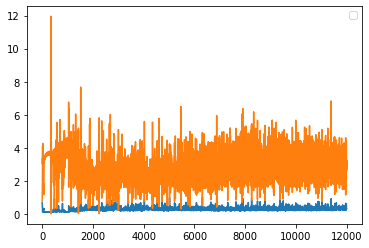

In [6]:
import matplotlib.pyplot as plt
plt.plot(d_loss_hist)
plt.plot(g_loss_hist)
plt.legend()